In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio

# We need to import pyWavelets
import pywt

### Load test image

In [2]:
img = (imageio.imread('tree.jpg')/255.).mean(axis=-1)
sh = img.shape

### Compute wavelet decomposition with chosen level and wavelet types

In [3]:
level = 5
wavelet = 'db4'
c = pywt.wavedec2(img, wavelet=wavelet, mode='periodization', level=level)

### Display result

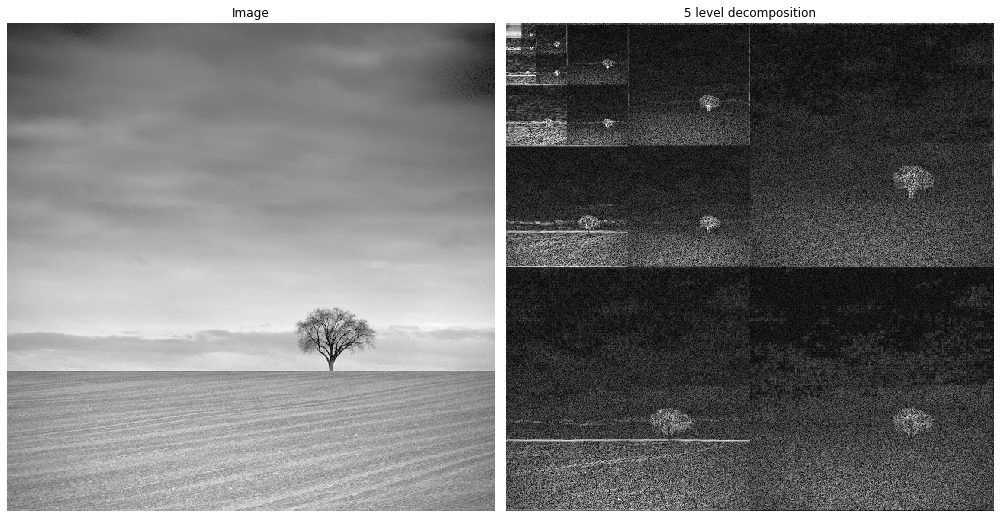

In [20]:
# We will apply a gamma transform to improve visibility
# (we can do img**gamma because img is already between 0 and 1)
gamma = .4

# For display it is better to normalize each coefficient independently
cn = [c[0]/np.abs(c[0]).max()]
for detail_level in range(1, level+1):
    cn.append( [d/np.abs(d).max() for d in c[detail_level]] )

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[14, 8])
ax1.set_axis_off()
ax1.imshow(img**gamma, cmap='gray')
ax1.set_title('Image')

arr, slices = pywt.coeffs_to_array(cn)
ax2.imshow(np.abs(arr)**gamma, cmap='gray')
ax2.set_axis_off()
ax2.set_title('%d level decomposition' % level)

plt.tight_layout()

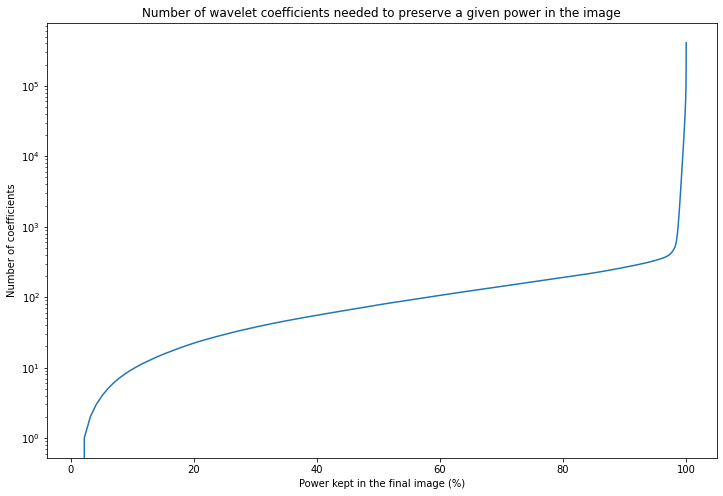

In [84]:
# It is more convenient to pack all coefficient in an array (as for display) 
carr, coeff_slices = pywt.coeffs_to_array(c)

# As for any other basis, the power of a given component is the squared magnitude of the coefficient
power = np.abs(carr)**2

# We want to visualise the number of coefficients needed to keep a certain % of the total power
# For this, we compute the cumulative sum of the power coefficients, from higher to lower
power_cummulative_sum = np.cumsum(np.sort(power.ravel())[::-1])
power_fraction = power_cummulative_sum / power_cummulative_sum[-1]

fig, ax = plt.subplots(figsize=[12, 8])
ax.plot(power_fraction*100, np.arange(len(power_fraction)))
ax.set_yscale('log')
ax.set_xlabel('Power kept in the final image (%)')
ax.set_ylabel('Number of coefficients');
ax.set_title('Number of wavelet coefficients needed to preserve a given power in the image');

In [101]:
power_thresholds = [.99, .995, .9995]
n_to_keep = [np.argmax(power_fraction>t) for t in power_thresholds]

(200, 781586.1088657631)

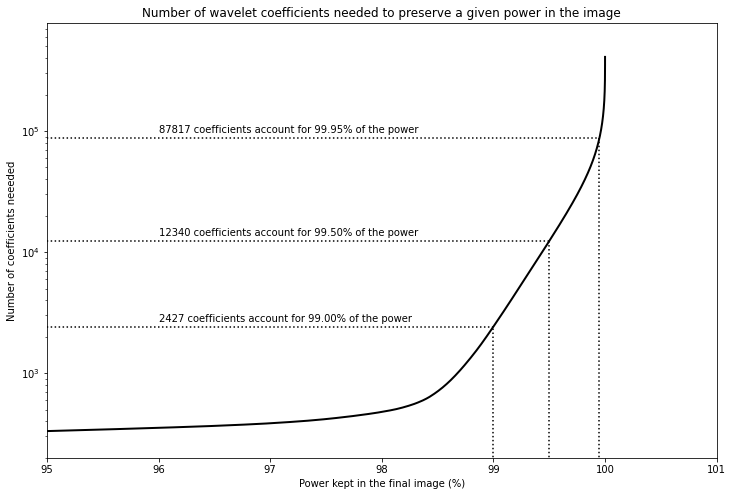

In [110]:
fig, ax = plt.subplots(figsize=[12, 8])
ax.plot(power_fraction*100, np.arange(len(power_fraction)), 'k-', lw=2)
for n, t in zip(n_to_keep, power_thresholds):
    ax.plot([100*t,100*t], [1, n], 'k:')
    ax.plot([0,100*t], [n, n], 'k:')
    ax.annotate('%d coefficients account for %5.2f%% of the power' % (n, 100*t), 
                xy=(96, n), 
                xytext=(.0, 5.), 
                textcoords='offset pixels')
ax.set_yscale('log')
ax.set_xlabel('Power kept in the final image (%)')
ax.set_ylabel('Number of coefficients neeeded')
ax.set_title('Number of wavelet coefficients needed to preserve a given power in the image');
ax.set_xlim(95,101)
ax.set_ylim(ymin=200)


In [111]:
imgrec = []
for n in n_to_keep:
    # Find lowest acceptable power value
    t = np.sort(power.ravel())[-n]
    print(t)
    # Set all smaller coefficients to 0
    carr_thresholded = carr*(power > t)
    # Reconstruct
    imgrec.append(pywt.waverec2(pywt.array_to_coeffs(carr_thresholded, coeff_slices, output_format='wavedec2'), wavelet=wavelet, mode='periodization'))

0.07722401158235577
0.014132263248206264
0.0006965558191173969


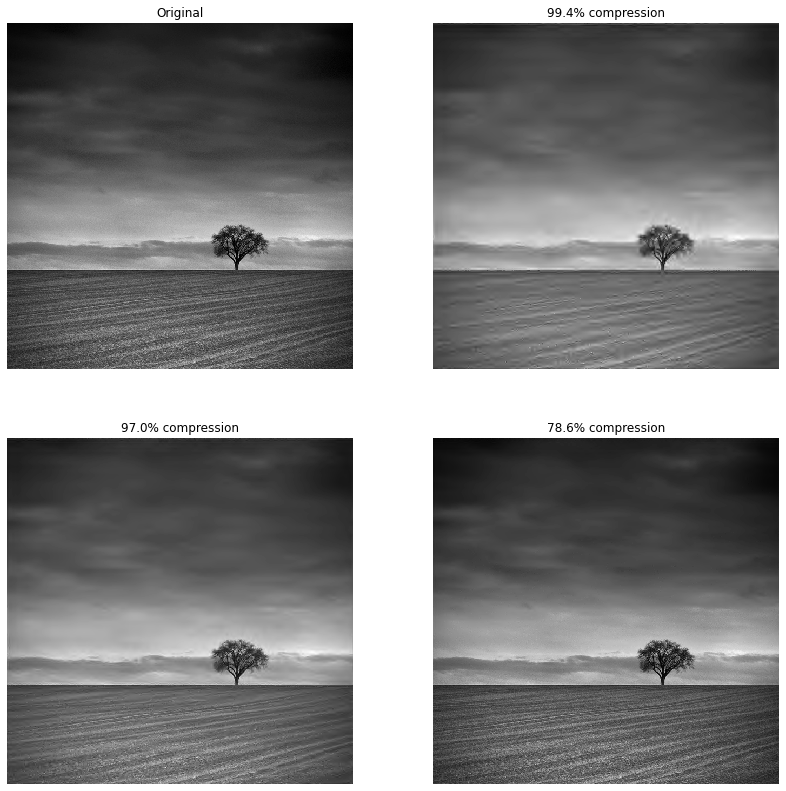

In [126]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=[14, 14])
ax1.set_axis_off()
ax1.imshow(img, cmap='gray')
ax1.set_title('Original')
i = 0
ax2.set_axis_off()
ax2.imshow(imgrec[i], cmap='gray')
ax2.set_title('%3.1f%% compression' % (100*(1 - n_to_keep[i]/power.size)))
i = 1
ax3.set_axis_off()
ax3.imshow(imgrec[i], cmap='gray')
ax3.set_title('%3.1f%% compression' % (100*(1 - n_to_keep[i]/power.size)))
i = 2
ax4.set_axis_off()
ax4.imshow(imgrec[i], cmap='gray')
ax4.set_title('%3.1f%% compression' % (100*(1 - n_to_keep[i]/power.size)));


In [121]:
[np.sum((im-img)**2)/np.sum(img**2) for im in imgrec]

[0.010001832289139942, 0.005000401373247731, 0.0005000182194711202]